<a href="https://colab.research.google.com/github/alexngocvu/Personal-Project/blob/main/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science for Business

## 📝 Linear Regression – Comprehensive Step‑by‑Step Tutorial
*Generated 2025-04-28*


Welcome! This notebook is intentionally **verbose and beginner‑friendly**. It alternates intuition, math, code, and visual checks so that every new concept builds naturally on the last.

## Table of Contents
1. Intuitive Idea  
2. Classical Assumptions  
3. Cost Function – MSE  
4. Closed‑Form Solution  
5. Visualising the Cost Surface  
6. Gradient Descent (Batch)  
7. Stochastic & Mini‑Batch GD  
8. Evaluation Metrics  
9. Residual Diagnostics  
10. Regularisation Snapshot (Ridge)  
11. scikit‑learn One‑Liner  

## 1 Intuitive Idea — Drawing the *Best* Straight Line  

Imagine you keep a diary of **how many hours you study** and the **score you receive** on each test.  
When you scatter-plot those pairs, the dots march upward from left to right: more study time usually means a better grade. Linear regression is the formal way to turn that fuzzy “upward trend” into a precise **rule**.


#### A picture in words 📈  
Think of stretching a rubber band so it touches (or *almost* touches) every point:

* **Intercept $\,\beta_0$** – where the band would hit the *y*-axis if you shrank study time to zero hours. It answers,  
  *“With no studying at all, what score do we expect?”*

* **Slope $\,\beta_1$** – the band’s tilt.  If $\,\beta_1 = 3\,$, each extra study hour nudges the expected score **3 points higher**. A steeper tilt ⇒ studying pays off faster.

Mathematically we write  

$$
y \;=\; \beta_0 \;+\; \beta_1\,x \tag{1}
$$

but you can read it as:  

> **Predicted score** = **baseline score** + (**gain per hour**) × **hours studied**.


#### Why a *single* line?  
1. **Simplicity** – One straight edge often captures the main pattern without over-thinking.  
2. **Predictability** – Once you know $\beta_0$ and $\beta_1$, any future “hours → score” pair drops right onto the line.  
3. **Explainability** – Teachers (or bosses) immediately grasp “3 points per hour” more easily than a wiggly curve.

Of course, real points won’t sit perfectly on the line—life has distractions, tired days, lucky guesses.  
Later, we’ll measure those little gaps (called *residuals*) and adjust the line so the *typical* gap is as small as possible. First, though, let’s generate some sample data and **see** our intuition in action!

### 1.1 Import Libraries & Create a Toy Dataset

In [ ]:
import numpy as np, matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

n = 70
beta0_true, beta1_true = 5, 3
X = np.random.uniform(0, 10, n)
noise = np.random.normal(0, 4, n)
y = beta0_true + beta1_true * X + noise

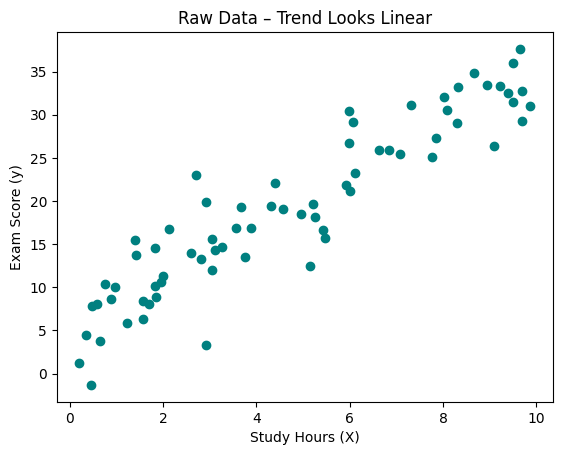

In [ ]:
plt.scatter(X, y, color='teal')
plt.xlabel('Study Hours (X)'); plt.ylabel('Exam Score (y)');
plt.title('Raw Data – Trend Looks Linear'); plt.show()

## 2 Classical Assumptions — What the Math *Really* Says and *Why* It Matters  

Linear regression’s neat formulas rely on four background “wishes” about the **errors**  
(the tiny gaps between each *observed* score $y_i$ and its *predicted* score $\hat y_i$).  
Below, each formal line now includes a quick decode of every symbol so students know *exactly* what it means.

| # | Formal statement (math) <br>*(with symbols unpacked)* | Intuitive picture | If it breaks… |
|---|---|---|---|
| **1. Linearity** | $$ \displaystyle y_i = \beta_0 + \beta_1 x_i \;+\; \varepsilon_i $$<br>• $y_i$: observed outcome for case *i*  <br>• $x_i$: input feature (study hours)  <br>• $\beta_0$: intercept (baseline score at $x=0$)  <br>•  $\beta_1$: slope (gain per extra hour)  <br>• $\varepsilon_i$: error for case *i* | Point cloud forms a straight **cigar**, not a banana. | A straight line can’t bend ⇒ residuals show a curved pattern. |
| **2. Independence** | $$ \displaystyle \operatorname{Cov}(\varepsilon_i,\;\varepsilon_j)=0 \quad (i\neq j) $$<br>• **Cov** is statistical “tug-along”—if it’s zero, errors don’t influence each other. | One student’s lucky guess is unrelated to another’s. | Errors clump together → standard errors look smaller than they really are. |
| **3. Homoscedasticity** <br>(equal spread) | $$ \displaystyle \operatorname{Var}(\varepsilon_i)=\sigma^{2}\quad\text{for every }i $$<br>• **Var** measures average squared wiggle.  <br>• The single number $\sigma^{2}$ means *same* wiggle everywhere along the line. | Noise cloud has uniform thickness at every $x$. | If spread widens with $x$ (megaphone), OLS (Ordinary Least Squares) is still unbiased but no longer the most efficient. |
| **4. Normality** | $$ \displaystyle \varepsilon_i \;\sim\; \mathcal N(0,\sigma^{2}) $$<br>• “$\sim$” means “is distributed as.”  <br>• $\mathcal N(0,\sigma^{2})$: bell curve centered at 0 with variance $\sigma^{2}$. | Error histogram looks like a bell. | Mostly hurts **p-values** & **confidence intervals**; point estimates stay unbiased thanks to least-squares geometry. |

---

#### Quick intuition checks 🔍
* **Residuals vs $x$** → random pepper, not a smile/frown → tests Linearity & Homoscedasticity.  
* **Histogram or Q-Q plot of residuals** → bell-ish → checks Normality.  
* **Durbin–Watson (or eyeballing residual order)** → checks Independence.

> **Take-home:** even when the world is messy, the fitted line ($\hat\beta_0,\hat\beta_1$) is still the *best* straight-line summary (unbiased).  
> What crumbles first are the **uncertainty statements**—standard errors, $t$-tests, and prediction intervals assume those four wishes for perfect calibration.

## 3 Cost Function — Mean Squared Error (MSE)  

To *teach the computer* what “best‐fit” means, we need a single number that tells us *how bad* a particular line is.  
That number is the **Mean Squared Error**.

---

#### 3.1 Building the pieces  

| Symbol | Name | Verbal meaning |
|---|---|---|
| $ \hat y_i =\beta_0 + \beta_1 x_i $ | **Prediction** (or *fitted value*) | The score our line *expects* for the $i$-th student who studied $x_i$ hours. |
| $ e_i = y_i - \hat y_i $ | **Residual** | The *real* minus the *predicted* score — the vertical gap from each dot to the line. |
| $ n $ | Sample size | Number of data points. |

---

#### 3.2 From gaps to one “badness” number  

1. **Square each residual** $(e_i^2)$ so negative and positive gaps don’t cancel out.  
2. **Add them up** to get the *Residual Sum of Squares* (RSS):  
   $$
   \text{RSS} = \sum_{i=1}^{n} e_i^{2}.
   $$
3. **Average** by dividing by \(n\) — that gives the **Mean Squared Error**:  
   $$
   J(\beta_0,\beta_1)=\frac{1}{n}\sum_{i=1}^{n}\bigl(y_i-(\beta_0+\beta_1 x_i)\bigr)^2.
   $$

> **Geometric view:**  
> In $n$-dimensional space the vector of residuals $\mathbf e$ has squared length $\lVert\mathbf e\rVert^{2} = n\,J$.  
> Minimising $J$ therefore means “make the residual vector as short as possible.”

---

#### 3.3 Why **squares** and not absolute values?  

| Reason | Short explanation |
|---|---|
| **Calculus-friendly** | The square is smooth and differentiable everywhere → easy gradient formulas. |
| **Penalises big mistakes more** | Squaring magnifies large residuals, pulling the line toward outliers. |
| **Leads to closed-form solution** | Setting derivatives of the squared loss to zero produces the Normal Equation. |

*(For data with extreme outliers you might prefer **Mean Absolute Error**, but then you lose the neat algebraic solution.)*

---

#### 3.4 What “minimising $J$” accomplishes  

Finding  
$$
(\hat\beta_0,\hat\beta_1)=\arg\min_{\beta_0,\beta_1} J(\beta_0,\beta_1)
$$

guarantees that **no other straight line** can achieve a smaller average squared gap.  
Two standard routes to that minimum:

* **Closed-form (Normal Equation)** – one matrix inverse, exact answer.  
* **Gradient Descent** – iterative updates, scales to millions of points.

We’ll explore both methods right after visualising how $J$ changes with different $\beta_0,\beta_1$.

### 4 Closed-Form Solution — the **Normal Equation**

Once we have the MSE loss  
$J(\beta_0,\beta_1)$, we can **solve for the minimum in one shot**—no iterative loops—using a bit of matrix calculus.

---

#### 4.1 Build the **design matrix**

$$
\mathbf X \;=\;
\begin{bmatrix}
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_{n}
\end{bmatrix},
\qquad
\mathbf y \;=\;
\begin{bmatrix}
y_1 \\[2pt] y_2 \\[2pt] \vdots \\[2pt] y_n
\end{bmatrix},
\qquad
\boldsymbol\beta \;=\;
\begin{bmatrix}
\beta_{0} \\[2pt] \beta_{1}
\end{bmatrix}.
$$

* **Column 1** of $\mathbf X$ (all ones) captures the intercept.  
* **Column 2** holds the input feature $x$.  
* Each row is one observation (student, house, patient …).

The vector of **predictions** is simply  

$$
\hat{\mathbf y}= \mathbf X\boldsymbol\beta .
$$

---

#### 4.2 Rewrite the loss in matrix form  

The **Residual Sum of Squares** (RSS) is  

$$
\text{RSS} \;=\; (\mathbf y-\mathbf X\boldsymbol\beta)^{\!\top}
              (\mathbf y-\mathbf X\boldsymbol\beta).
$$

Dividing by $n$ gives the MSE $J$; the minimiser $\boldsymbol\beta$ is identical because $1/n$ is a constant factor.

---

#### 4.3 Take the gradient and set it to zero  

$$
\nabla_{\!\boldsymbol\beta}\,
\bigl[(\mathbf y-\mathbf X\boldsymbol\beta)^{\!\top}
      (\mathbf y-\mathbf X\boldsymbol\beta)\bigr]
= -2\,\mathbf X^{\!\top}\!\bigl(\mathbf y-\mathbf X\boldsymbol\beta\bigr).
$$

Setting the gradient to zero:

$$
-2\,\mathbf X^{\!\top}(\mathbf y-\mathbf X\boldsymbol\beta)=\mathbf 0
\;\Longrightarrow\;
\boxed{\; \mathbf X^{\!\top}\mathbf X\,\boldsymbol\beta
       = \mathbf X^{\!\top}\mathbf y\; }.
$$

---

#### 4.4 Solve the linear system  

If $\mathbf X^{\!\top}\mathbf X$ is **invertible**—i.e. $x$ is **not a constant** so that the two columns of $\mathbf X$ are linearly independent—

$$
\boxed{\;
\hat{\boldsymbol\beta} \;=\;
(\mathbf X^{\!\top}\mathbf X)^{-1}\mathbf X^{\!\top}\mathbf y\; }.
$$

This is the **Normal Equation**, yielding the ordinary least-squares (OLS) estimator.

* $\hat\beta_0$ and $\hat\beta_1$ minimise RSS/MSE.  
* Under the Gauss–Markov assumptions  
  *(linearity, independent errors, homoscedasticity, full rank)*  
  they are the **Best Linear Unbiased Estimators (BLUE)**.

---

#### 4.5 Geometric intuition  

* $\mathbf X\boldsymbol\beta$ sweeps out a **2-D plane** in $\mathbb R^{n}$.  
* The solution projects $\mathbf y$ **orthogonally** onto that plane.  
* The residual vector $\mathbf e=\mathbf y-\mathbf X\hat{\boldsymbol\beta}$ is therefore orthogonal to every column of $\mathbf X$ (zero-gradient condition).

---

#### 4.6 Numerical notes  

* **Near-singular $\mathbf X^{\!\top}\mathbf X$** (multicollinearity)  
  → use the Moore–Penrose pseudoinverse: `np.linalg.pinv(X)`.

* **Large feature dimension $p$**  
  *Compute cost*  
  $\mathcal O(np^{2})$ for building $\mathbf X^{\!\top}\mathbf X$  
  $\mathcal O(p^{3})$ for inverting it.  
  For large $p$, prefer (stochastic) gradient descent.

* **Floating-point stability**  
  → centre and scale features before forming $\mathbf X^{\!\top}\mathbf X$.

In [ ]:
X_b = np.c_[np.ones_like(X), X]
beta_hat = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y
b_hat, m_hat = beta_hat
print(f'β0 ≈ {b_hat:.3f}\nβ1 ≈ {m_hat:.3f}')

β0 ≈ 5.178
β1 ≈ 2.983


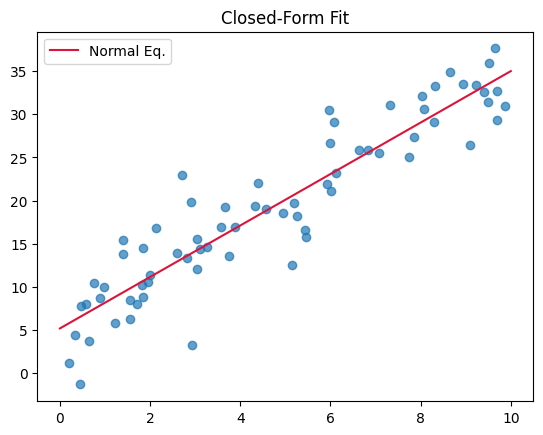

In [ ]:
plt.scatter(X, y, alpha=0.7)
xs = np.linspace(0, 10, 100)
plt.plot(xs, m_hat*xs + b_hat, color='crimson', label='Normal Eq.')
plt.legend(); plt.title('Closed‑Form Fit'); plt.show()

## 5 Visualising the Cost Surface — *Why the Minimum Is Easy to Find*  

Numbers alone can feel abstract.  Plotting the loss function  
$$
J(\beta_0,\beta_1)=\frac1n\sum_{i=1}^{n}\!\bigl(y_i-(\beta_0+\beta_1x_i)\bigr)^2
$$  
as a 3-D surface lets you *see* that:

* the landscape is a smooth **bowl** (a convex paraboloid),  
* there is **one and only one** bottom point (the global minimum),  
* every gradient-descent step simply follows the slope downhill.


#### 5.1 Axes and what they mean  

| Axis | Represents | Units |
|------|------------|-------|
| **X-axis** | Intercept candidate $ \beta_0 $ | score points |
| **Y-axis** | Slope candidate $ \beta_1 $ | score-gain per study-hour |
| **Z-axis** | Loss value $ J(\beta_0,\beta_1) $ | mean squared error |

Every coordinate pair $(\beta_0,\beta_1)$ on the floor generates a *vertical* height $J$:  
large height ⇒ poor fit; valley floor ⇒ best fit.



### 5.2 What you’ll see in the 3-D plot  

* A smooth, curved “**Mexican hat**” without ridges or extra pits — that’s convexity in action.  
* A single lowest point; drop a marble anywhere on the bowl and it rolls to that same spot.  
  *That* spot’s coordinates are exactly the Normal-Equation solution $(\hat\beta_0,\hat\beta_1)$.



### 5.3 Optional 2-D contour view  

If you draw a contour (heat-map) of $J$:

* Concentric **ellipses** appear, shrinking toward the centre.  
* The centre of the smallest ellipse is the optimum.  
* Super-impose the **gradient-descent path** (store $\beta$ after each epoch) to show how the algorithm spirals into the bull’s-eye.


### 5.4 Why this bowl shape matters  

1. **Convex = safe:** No local minima → any descent method finds the same answer.  
2. **Curvature tells step size:** The bowl’s steepness near the sides explains why too-large a learning rate makes the algorithm overshoot and bounce.  
3. **Hessian insight:** The matrix $\mathbf X^{\!\top}\mathbf X$ is the (scaled) Hessian of $J$; its eigen-values determine how round or stretched the bowl is (and thus how quickly Gradient Descent converges along each axis).

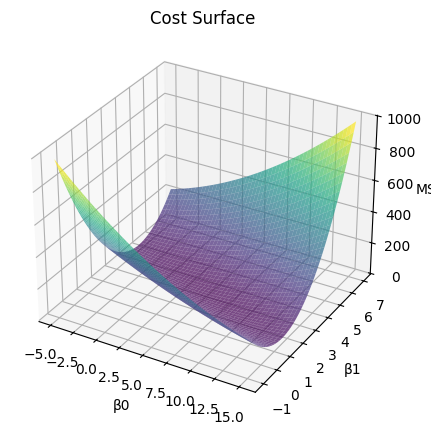

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
b_range = np.linspace(b_hat-10, b_hat+10, 50)
m_range = np.linspace(m_hat-4,  m_hat+4, 50)
B, M = np.meshgrid(b_range, m_range)
J = np.zeros_like(B)
for i in range(B.shape[0]):
    for j in range(B.shape[1]):
        y_hat = M[i,j]*X + B[i,j]
        J[i,j] = ((y - y_hat)**2).mean()
fig = plt.figure(figsize=(6,5)); ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(B, M, J, cmap='viridis', alpha=0.7)
ax.set_xlabel('β0'); ax.set_ylabel('β1'); ax.set_zlabel('MSE');
plt.title('Cost Surface'); plt.show()

## 6 Gradient Descent (Batch) — *Learning* the Line One Step at a Time  

Even though the Normal-Equation gives us the coefficients in a single algebraic leap, real-world machine-learning often relies on **Gradient Descent (GD)** because:

* The same idea scales to **dozens or thousands of features** (no giant matrix inverse).  
* A tiny change switches you to **Stochastic** or **Mini-Batch** GD for streaming or big-data settings.  
* The algorithmic pattern generalises to neural networks.

---

#### 6.1 The update rule — “walk downhill”  

$$
\boxed{\;
\beta_j \;\leftarrow\; \beta_j \;-\; \alpha\,
          \frac{\partial J}{\partial \beta_j},
\quad j=0,1
\;} \tag{4}
$$

* **\(\alpha\)** (learning rate): the step size in parameter space.  
  * Too small → painfully slow convergence.  
  * Too large → you may overshoot the valley and diverge.  
  * A common trick is to **start larger** and then **decay** \(\alpha\) every few epochs.

---

#### 6.2 Where the gradients come from  

Starting with  

$$
J(\beta_0,\beta_1)=\frac{1}{n}\sum_{i=1}^{n}\!
      \bigl(y_i-(\beta_0+\beta_1 x_i)\bigr)^2,
$$

take partial derivatives (chain rule):

$$
\frac{\partial J}{\partial \beta_0}
  = \frac1n \sum_{i=1}^{n} 2\bigl(y_i-\hat{y}_i\bigr)(-1)
  = -\frac{2}{n}\sum_{i=1}^{n}\!\bigl(y_i-\hat{y}_i\bigr),
$$

$$
\frac{\partial J}{\partial \beta_1}
  = \frac1n \sum_{i=1}^{n} 2\bigl(y_i-\hat{y}_i\bigr)(-x_i)
  = -\frac{2}{n}\sum_{i=1}^{n}\!x_i\bigl(y_i-\hat{y}_i\bigr). \tag{5}
$$

Here \( \hat{y}_i = \beta_0+\beta_1 x_i \) is the current prediction with the *latest* coefficients.

---

#### 6.3 Vector-form shortcut  

Define  

$$
\mathbf X =
\begin{bmatrix}
1 & x_1\\[-2pt]\vdots & \vdots\\[-2pt]1 & x_n
\end{bmatrix},
\quad
\boldsymbol\beta=
\begin{bmatrix}\beta_0\\[2pt]\beta_1\end{bmatrix},
\quad
\mathbf e=\mathbf y-\mathbf X\boldsymbol\beta .
$$

Then the gradient is  

$$
\nabla_{\!\boldsymbol\beta}J
  = -\tfrac{2}{n}\,\mathbf X^{\!\top}\mathbf e,
$$

and the update becomes one terse line of code:

```python
beta -= alpha * (-2/n) * X.T @ (y - X @ beta)
```

#### 6.4 Pseudocode (Batch GD)

```text
initialise β0, β1          # often 0 or small random
repeat until convergence:
    y_hat  = β0 + β1 * X   # vectorised predictions
    error  = y_hat - y
    grad0  = 2 * error.mean()
    grad1  = 2 * (error * X).mean()
    β0    -= α * grad0
    β1    -= α * grad1
```

*Stop condition*: small change in $J$ or a fixed number of epochs.

---

#### 6.5 How the learning rate shapes the path  

| Scenario | Visual on cost-surface bowl | Outcome |
|----------|----------------------------|---------|
| $\alpha$ tiny (e.g.\ 0.0001) | many teensy steps hugging the valley wall | Converges safely but very slow. |
| Ideal $\alpha$ | graceful spiral straight to the bottom | Fastest stable convergence. |
| $\alpha$ too large | steps leap over the minimum, bouncing ridge-to-ridge | Diverges or oscillates. |

Plotting the **learning curve** (MSE vs. iteration) helps diagnose overshoot (curve spikes upward) or sluggishness (flat tail).

---

#### 6.6 Batch vs. Mini-Batch vs. Stochastic  

| Variant | Data per update | Pros | Cons |
|---------|-----------------|------|------|
| **Batch** | All $n$ points | Exact gradient → smooth convergence | Costly for very large $n$ |
| **Mini-Batch** | e.g.\ 32 or 128 points | Fast on GPUs, still fairly stable | Need to pick batch size |
| **Stochastic GD** | 1 point | Can escape shallow local minima, good for streams | Noisy path, needs smaller $\alpha$ |

*(For plain linear regression the cost surface is convex, so Batch GD is already guaranteed to find the one global minimum; Mini-Batch/SGD are mainly about computational efficiency.)*

---

#### 6.7 Practical tips 🛠️  

* **Feature scaling** (centering and standardising $x$) speeds GD by making the bowl rounder (condition number smaller).  
* Record $J$ every epoch; stop when relative improvement $<10^{-6}$ for, say, 10 consecutive epochs.  
* If you see *NaN* explode, reduce $\alpha$ or check for data entry errors/outliers.

With this foundation you can now **implement batch GD, mini-batch, or stochastic** by changing just two lines of code—and watch how the learning curve behaves in each case.

In [ ]:
α, epochs = 0.01, 900
b_gd, m_gd = 0.0, 0.0
mse_hist = []
for _ in range(epochs):
    y_pred = m_gd*X + b_gd
    err = y_pred - y
    b_gd -= α*2*err.mean()
    m_gd -= α*2*np.mean(err*X)
    mse_hist.append(np.mean(err**2))
print(f'After GD: β0 ≈ {b_gd:.3f}, β1 ≈ {m_gd:.3f}')

After GD: β0 ≈ 5.152, β1 ≈ 2.987


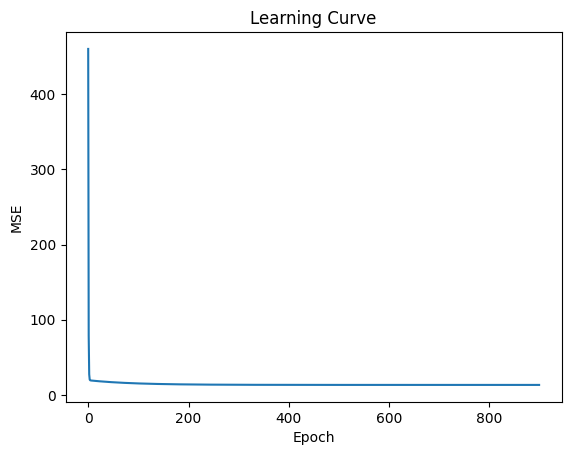

In [ ]:
plt.plot(mse_hist); plt.xlabel('Epoch'); plt.ylabel('MSE');
plt.title('Learning Curve'); plt.show()

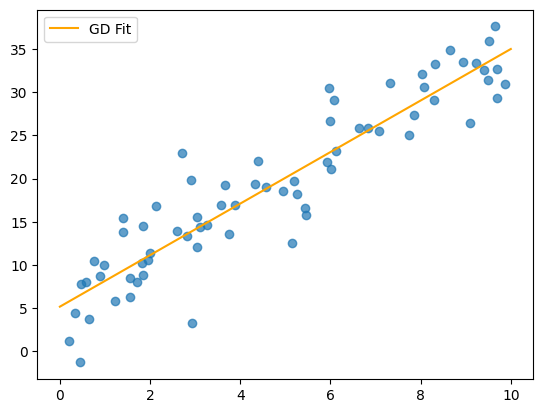

In [ ]:
plt.scatter(X, y, alpha=0.7)
plt.plot(xs, m_gd*xs + b_gd, color='orange', label='GD Fit')
plt.legend(); plt.show()

## 7 SGD / Mini‑Batch (quick demo)
SGD updates after *one* sample; mini‑batch after small groups.

In [ ]:
α_sgd = 0.005
b_sgd, m_sgd = 0.0, 0.0
for epoch in range(3):
    for xi, yi in zip(X, y):
        err = (m_sgd*xi + b_sgd) - yi
        b_sgd -= α_sgd*2*err
        m_sgd -= α_sgd*2*err*xi
print(f'SGD β0 ≈ {b_sgd:.3f}, β1 ≈ {m_sgd:.3f}')

SGD β0 ≈ 2.430, β1 ≈ 2.904


## 8 Evaluation Metrics
- **RMSE**, **MAE**, **$R^2$**.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred_cf = m_hat*X + b_hat
print('RMSE', mean_squared_error(y, y_pred_cf, squared=False))
print('MAE ', mean_absolute_error(y, y_pred_cf))
print('R^2 ', r2_score(y, y_pred_cf))

TypeError: got an unexpected keyword argument 'squared'

## 9 Residual Diagnostics

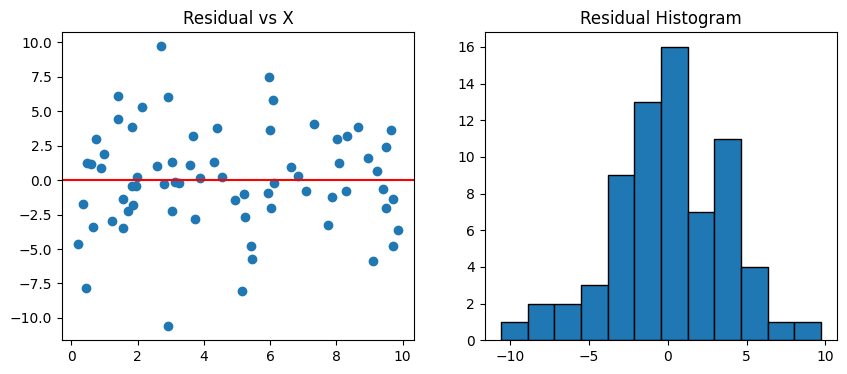

In [ ]:
resid = y - y_pred_cf
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(X, resid); ax[0].axhline(0, color='r'); ax[0].set_title('Residual vs X')
ax[1].hist(resid, bins=12, edgecolor='k'); ax[1].set_title('Residual Histogram')
plt.show()

## 10 Regularisation Snapshot – Ridge

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0).fit(X.reshape(-1,1), y)
print('Ridge β0', ridge.intercept_, 'β1', ridge.coef_[0])

Ridge β0 5.19978522421499 β1 2.9782397822047573


## 11 scikit‑learn One‑Liner

In [ ]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression().fit(X.reshape(-1,1), y)
print('sklearn β0', lin.intercept_, 'β1', lin.coef_[0])

sklearn β0 5.177944685882727 β1 2.9829117331800026
